# Analyzing the sampled Blackjack data

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import time
import json
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]

Import blackjack samples data.  This is a dataframe consisting of four iterations of a sampling of 1,000,000 consecutive rounds of blackjack with each iteration played using a different strategy: naive, copycat, basic, and counter.  The games are played with 6 decks, penetration 1.5, Blackjack pays 3 to 2, and dealer playing H17.

In [2]:
df = pd.read_csv('../large sample/38__6_decks_pen_1.5_BJpays_[3, 2]_dealerplays_H17_1000000_samples.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Filter to the counter strategy.

In [3]:
df_counter = df[df['strategy'] == 'counter']
df_counter.reset_index(drop=True, inplace=True)
df_counter.head()

,decks,pen,Blackjack_pays,Dealer_seventeen,strategy,spread,opening_count,cards_left,spots,bets,double_down,player_hands,dealer_hand,player_results,dealer_result,insurance,player_winnings_by_hand,total_round_winnings,accumulated_winnings
0,6,1.5,"[3, 2]",H17,counter,"{-1: [1, 1], 0: [1, 1], 1: [1, 2], 2: [4, 2], ...",0,307,1,[1],[False],"[[8, 5, 10]]","[10, 10]",[['bust']],['stand'],False,[-1.0],-1.0,-1.0
1,6,1.5,"[3, 2]",H17,counter,"{-1: [1, 1], 0: [1, 1], 1: [1, 2], 2: [4, 2], ...",0,299,1,[1],[False],"[[10, 6]]","[4, 5, 3, 'A', 3, 5]",[['stand']],['stand'],False,[-1.0],-1.0,-2.0
2,6,1.5,"[3, 2]",H17,counter,"{-1: [1, 1], 0: [1, 1], 1: [1, 2], 2: [4, 2], ...",0,294,1,[1],[False],"[[9, 4, 6]]","[10, 10]",[['stand']],['stand'],False,[-1.0],-1.0,-3.0
3,6,1.5,"[3, 2]",H17,counter,"{-1: [1, 1], 0: [1, 1], 1: [1, 2], 2: [4, 2], ...",0,288,1,[1],[False],"[[10, 10]]","[2, 5, 6, 7]",[['stand']],['stand'],False,[0.0],0.0,-3.0
4,6,1.5,"[3, 2]",H17,counter,"{-1: [1, 1], 0: [1, 1], 1: [1, 2], 2: [4, 2], ...",0,283,1,[1],[False],"[[8, 10]]","['A', 'A', 9]",[['stand']],['stand'],False,[-1.0],-1.0,-4.0


In [4]:
df_counter.describe()

,decks,pen,opening_count,cards_left,spots,total_round_winnings,accumulated_winnings
count,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,6.0,1.5,0.607768,216.753253,1.293703,0.087893,42094.407790
std,0.0,0.0,1.611568,64.731212,0.455458,6.088452,24848.212488
min,6.0,1.5,-1.000000,62.000000,1.000000,-120.000000,-36.000000
25%,6.0,1.5,0.000000,169.000000,1.000000,-1.000000,21025.500000
50%,6.0,1.5,0.000000,228.000000,1.000000,0.000000,40471.500000
75%,6.0,1.5,1.000000,272.000000,2.000000,1.000000,62599.625000
max,6.0,1.5,20.000000,308.000000,2.000000,120.000000,87907.000000


In [5]:
df_basic = df[df['strategy']=='basic']
df_basic.reset_index(drop=True, inplace=True)
df_basic.describe()

,decks,pen,opening_count,cards_left,spots,total_round_winnings,accumulated_winnings
count,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000.000000
mean,6.0,1.5,-0.043995,190.676268,1.0,0.004443,2331.347320
std,0.0,0.0,2.408798,68.521215,0.0,1.169036,1497.339038
min,6.0,1.5,-19.000000,58.000000,1.0,-12.000000,-56.000000
25%,6.0,1.5,-1.000000,131.000000,1.0,-1.000000,801.500000
50%,6.0,1.5,0.000000,191.000000,1.0,0.000000,2559.500000
75%,6.0,1.5,1.000000,250.000000,1.0,1.000000,3757.000000
max,6.0,1.5,20.000000,308.000000,1.0,11.000000,4619.000000


In [6]:
df_cc = df[df['strategy']=='cc']
df_cc.reset_index(drop=True, inplace=True)
df_cc.describe()

,decks,pen,opening_count,cards_left,spots,total_round_winnings,accumulated_winnings
count,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000.000000
mean,6.0,1.5,-0.048238,190.709030,1.0,-0.062031,-30648.110449
std,0.0,0.0,2.411463,68.508093,0.0,0.977468,17921.773129
min,6.0,1.5,-20.000000,66.000000,1.0,-1.000000,-62043.500000
25%,6.0,1.5,-1.000000,131.000000,1.0,-1.000000,-46415.000000
50%,6.0,1.5,0.000000,191.000000,1.0,0.000000,-30330.000000
75%,6.0,1.5,1.000000,250.000000,1.0,1.000000,-15435.000000
max,6.0,1.5,18.000000,308.000000,1.0,1.500000,-0.500000


In [7]:
df_naive = df[df['strategy']=='naive']
df_naive.reset_index(drop=True, inplace=True)
df_naive.describe()

,decks,pen,opening_count,cards_left,spots,total_round_winnings,accumulated_winnings
count,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000.000000
mean,6.0,1.5,-0.040354,190.856490,1.0,-0.076791,-38365.217149
std,0.0,0.0,2.407290,68.482129,0.0,0.995109,22108.096874
min,6.0,1.5,-19.000000,68.000000,1.0,-1.000000,-76792.000000
25%,6.0,1.5,-1.000000,132.000000,1.0,-1.000000,-57648.000000
50%,6.0,1.5,0.000000,191.000000,1.0,-1.000000,-38052.500000
75%,6.0,1.5,1.000000,250.000000,1.0,1.000000,-19363.875000
max,6.0,1.5,19.000000,308.000000,1.0,1.500000,14.000000


## Sampling the minimum of accumulated winnings

In [8]:
# obtain list of minimum accumulated winnings (biggest losses)
# of random samples of 50000 consecutive games

mins = []
np.random.seed(11)
start_indexes = np.random.choice(950000, size=100000, replace=False)
for i in start_indexes:
    sample50k = np.array(df_counter.loc[i:i + 49999, 'accumulated_winnings'])
    if i != 0:
        mins.append(sample50k.min() - df_counter.loc[i-1,'accumulated_winnings'])
    else:
        mins.append(sample50k.min())
    
print(np.mean(np.array(mins)))


-187.496185


In [9]:
mins = np.array(mins)

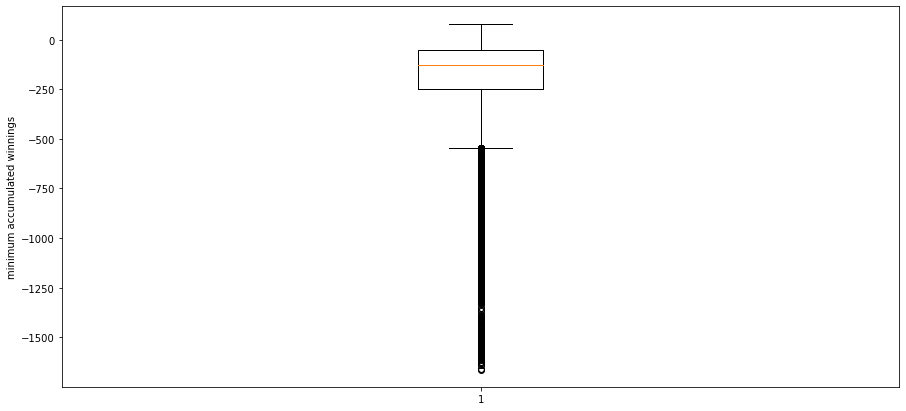

In [10]:
plt.boxplot(mins)
plt.ylabel('minimum accumulated winnings')
plt.show()

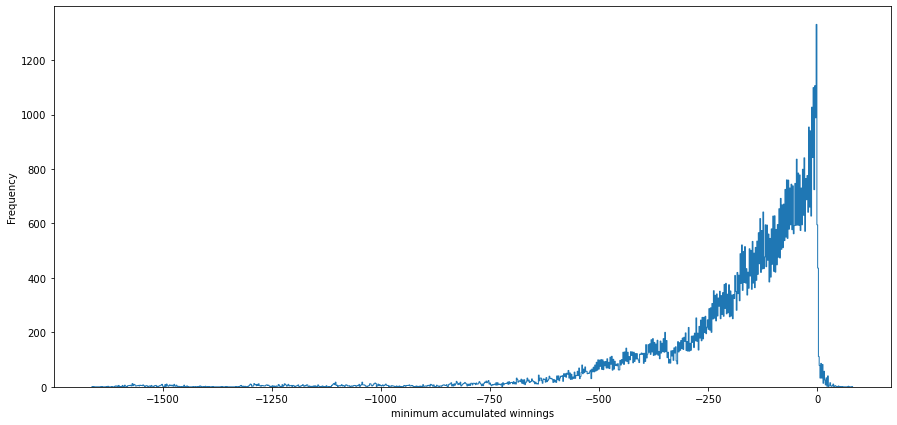

In [11]:
plt.hist(mins, bins=1000, histtype='step')
plt.xlabel('minimum accumulated winnings')
plt.ylabel('Frequency')
plt.show()

In [12]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1)/len(x)
    return x, y

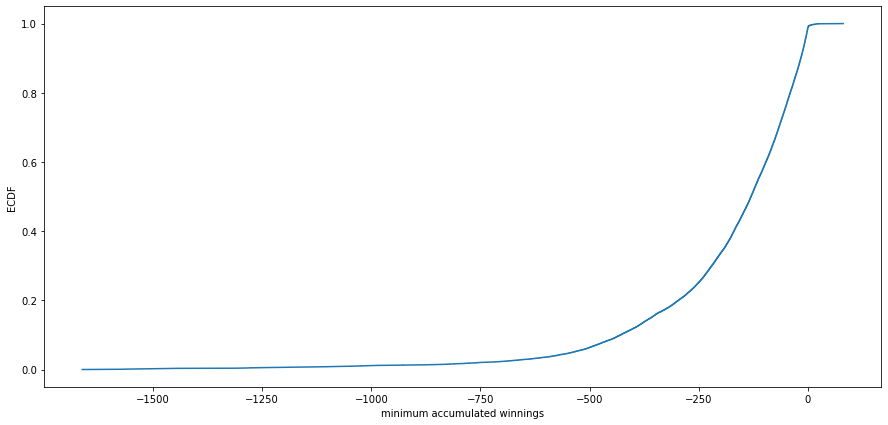

In [13]:
x, y = ecdf(mins)
plt.plot(x, y)
plt.xlabel('minimum accumulated winnings')
plt.ylabel('ECDF')
plt.show()

In [14]:
def losses(df):
    df.reset_index(drop=True, inplace=True)
    mins = []
    np.random.seed(11)
    start_indexes = np.random.choice(950000, size=100000, replace=False)
    for i in start_indexes:
        sample50k = np.array(df.loc[i:i + 49999, 'accumulated_winnings'])
        if i != 0:
            mins.append(sample50k.min() - df.loc[i-1,'accumulated_winnings'])
        else:
            mins.append(sample50k.min())
            
    plt.boxplot(mins)
    plt.ylabel('minimum accumulated winnings')
    plt.show()
    
    plt.hist(mins, bins=1000, histtype='step')
    plt.xlabel('minimum accumulated winnings')
    plt.ylabel('Frequency')
    plt.show()
    
    x, y = ecdf(mins)
    plt.plot(x, y)
    plt.xlabel('minimum accumulated winnings')
    plt.ylabel('ECDF')
    plt.show()
    
    return mins

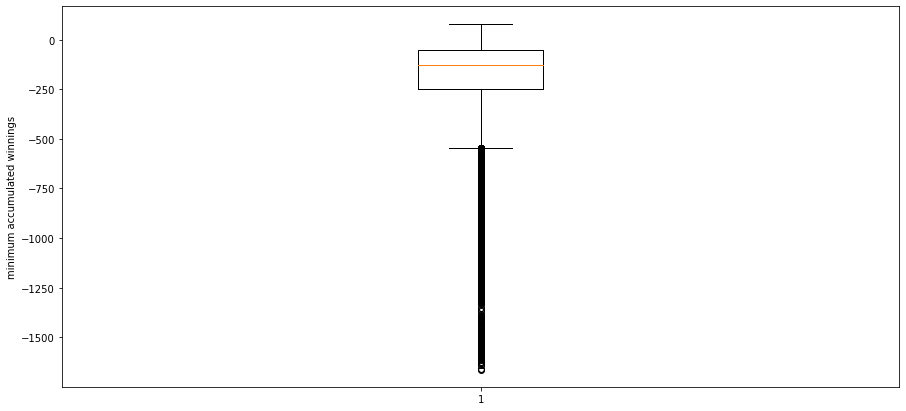

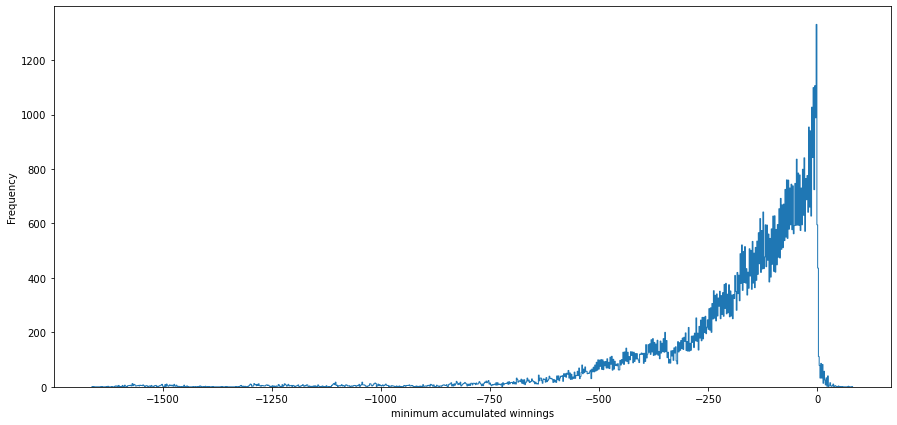

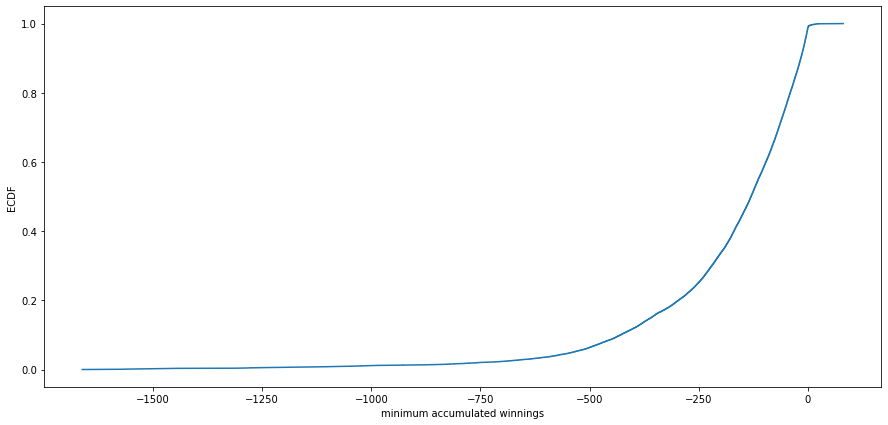

In [15]:
mins = losses(df_counter)

In [16]:
np.percentile(mins,[0,5])

array([-1662.5,  -538.5])

In [17]:
df_counter

,decks,pen,Blackjack_pays,Dealer_seventeen,strategy,spread,opening_count,cards_left,spots,bets,double_down,player_hands,dealer_hand,player_results,dealer_result,insurance,player_winnings_by_hand,total_round_winnings,accumulated_winnings
0,6,1.5,"[3, 2]",H17,counter,"{-1: [1, 1], 0: [1, 1], 1: [1, 2], 2: [4, 2], ...",0,307,1,[1],[False],"[[8, 5, 10]]","[10, 10]",[['bust']],['stand'],False,[-1.0],-1.0,-1.0
1,6,1.5,"[3, 2]",H17,counter,"{-1: [1, 1], 0: [1, 1], 1: [1, 2], 2: [4, 2], ...",0,299,1,[1],[False],"[[10, 6]]","[4, 5, 3, 'A', 3, 5]",[['stand']],['stand'],False,[-1.0],-1.0,-2.0
2,6,1.5,"[3, 2]",H17,counter,"{-1: [1, 1], 0: [1, 1], 1: [1, 2], 2: [4, 2], ...",0,294,1,[1],[False],"[[9, 4, 6]]","[10, 10]",[['stand']],['stand'],False,[-1.0],-1.0,-3.0
3,6,1.5,"[3, 2]",H17,counter,"{-1: [1, 1], 0: [1, 1], 1: [1, 2], 2: [4, 2], ...",0,288,1,[1],[False],"[[10, 10]]","[2, 5, 6, 7]",[['stand']],['stand'],False,[0.0],0.0,-3.0
4,6,1.5,"[3, 2]",H17,counter,"{-1: [1, 1], 0: [1, 1], 1: [1, 2], 2: [4, 2], ...",0,283,1,[1],[False],"[[8, 10]]","['A', 'A', 9]",[['stand']],['stand'],False,[-1.0],-1.0,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,6,1.5,"[3, 2]",H17,counter,"{-1: [1, 1], 0: [1, 1], 1: [1, 2], 2: [4, 2], ...",0,308,1,[1],[False],"[[10, 7]]","[10, 8]",[['stand']],['stand'],False,[-1.0],-1.0,87893.5
999996,6,1.5,"[3, 2]",H17,counter,"{-1: [1, 1], 0: [1, 1], 1: [1, 2], 2: [4, 2], ...",0,304,1,[1],[False],"[['A', 10]]","[4, 6]",[['PBJ']],['stand'],False,[1.5],1.5,87895.0
999997,6,1.5,"[3, 2]",H17,counter,"{-1: [1, 1], 0: [1, 1], 1: [1, 2], 2: [4, 2], ...",0,299,1,[2],[True],"[[3, 8, 'A']]","[10, 8]",[['stand']],['stand'],False,[-2.0],-2.0,87893.0
999998,6,1.5,"[3, 2]",H17,counter,"{-1: [1, 1], 0: [1, 1], 1: [1, 2], 2: [4, 2], ...",0,293,1,[1],[False],"[[4, 10]]","[3, 5, 2, 10]",[['stand']],['stand'],False,[-1.0],-1.0,87892.0


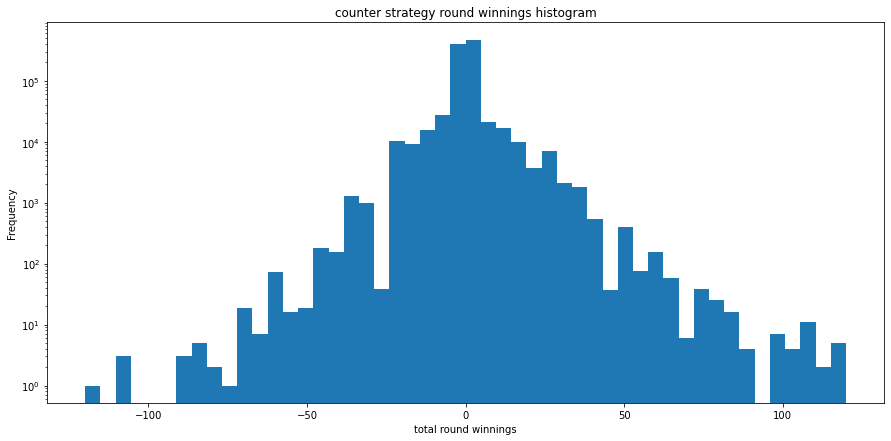

In [18]:
plt.hist(df_counter['total_round_winnings'], bins=50)
plt.title('counter strategy round winnings histogram')
plt.xlabel('total round winnings')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

## Simple Probabilities

For each strategy, compute the probability of winning, expected value, probability of winning on a positive count, expected value on a positive count, the fifth percentile losses.

In [19]:
%%capture

dic = {'counter': [], 'basic': [], 'cc': [], 'naive':[]}

dfs = {'counter': df_counter, 'basic':df_basic, 'cc':df_cc, 'naive':df_naive}

for strat in list(dfs.keys()):
    dic[strat].append(np.sum(dfs[strat]['total_round_winnings'] >=0)/1000000)
    dic[strat].append(np.mean(dfs[strat]['total_round_winnings']))
    dic[strat].append(np.sum((dfs[strat]['opening_count']>0) & (dfs[strat]['total_round_winnings']>= 0))
                      /np.sum(dfs[strat]['opening_count']>0) )  
    dic[strat].append(np.mean(dfs[strat][dfs[strat]['opening_count']>0]['total_round_winnings']))
    dic[strat].append(np.percentile(losses(dfs[strat]),[0,5])[1])

sim_prob = pd.DataFrame(dic)
sim_prob.index = ['probability of winning', 'expected value',\
                  'probability of winning on positive count',\
                  'expected value on positive count', 'fifth percentile loss']


In [20]:
sim_prob

,counter,basic,cc,naive
probability of winning,0.537606,0.521254,0.506255,0.480613
expected value,0.087893,0.004443,-0.062031,-0.076791
probability of winning on positive count,0.577944,0.526183,0.508247,0.491543
expected value on positive count,0.294411,0.019508,-0.054773,-0.055407
fifth percentile loss,-538.500000,-342.500000,-3398.500000,-4143.025000


## Hypothesis testing correlation between opening count and round winnings

In [22]:
# obtain basic strategy dataframe

df_basic = df[df['strategy']=='basic']

df_basic['accumulated_winnings'] = np.cumsum(df_basic['total_round_winnings'])

#df_basic.drop('Unnamed: 0', axis=1, inplace=True)
df_basic.reset_index(drop=True, inplace=True)
df_basic.head()

<ipython-input-22-e838a8835d38>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basic['accumulated_winnings'] = np.cumsum(df_basic['total_round_winnings'])


,decks,pen,Blackjack_pays,Dealer_seventeen,strategy,spread,opening_count,cards_left,spots,bets,double_down,player_hands,dealer_hand,player_results,dealer_result,insurance,player_winnings_by_hand,total_round_winnings,accumulated_winnings
0,6,1.5,"[3, 2]",H17,basic,NaN,0,307,1,[1],[False],"[[8, 5, 10]]","[10, 10]",[['bust']],['stand'],False,[-1.0],-1.0,-1.0
1,6,1.5,"[3, 2]",H17,basic,NaN,0,299,1,[1],[False],"[[10, 6]]","[4, 5, 3, 'A', 3, 5]",[['stand']],['stand'],False,[-1.0],-1.0,-2.0
2,6,1.5,"[3, 2]",H17,basic,NaN,0,294,1,[1],[False],"[[9, 4, 6]]","[10, 10]",[['stand']],['stand'],False,[-1.0],-1.0,-3.0
3,6,1.5,"[3, 2]",H17,basic,NaN,0,288,1,[1],[False],"[[10, 10]]","[2, 5, 6, 7]",[['stand']],['stand'],False,[0.0],0.0,-3.0
4,6,1.5,"[3, 2]",H17,basic,NaN,0,283,1,[1],[False],"[[8, 10]]","['A', 'A', 9]",[['stand']],['stand'],False,[-1.0],-1.0,-4.0


In [23]:
# permutation test function

def pearson(x,y):
    return np.corrcoef(x,y)[0][1]

def perm_test(arr1, arr2, coef=pearson, n_iter=10000):
    name1=arr1.name
    name2=arr2.name
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    true_coef = coef(arr1,arr2)
    
    permuted_coefs = []
    np.random.seed(2)
    for i in range(n_iter):
        arr1_perm = np.random.permutation(arr1)
        perm_coef = coef(arr1_perm,arr2)
        permuted_coefs.append(perm_coef)


    permuted_coefs = np.array(permuted_coefs)
    
    conf_int95 = np.percentile(permuted_coefs, [2.5,97.5])
    
    conf_int99 = np.percentile(permuted_coefs, [0.5,99.5])
    
    if true_coef >=0:
        p_value = np.sum(permuted_coefs >= true_coef)/10000
    else:
        p_value = np.sum(permuted_coefs <= true_coef)/10000
    
    print('Results for hypothesis test of %s of %s and %s'%(coef, name1, name2))
    print('True correlation coefficient: ', true_coef)
    print('95% confidence interval: ', conf_int95)
    print('99% confidence interval: ', conf_int99)
    print('p-value: ', p_value)
    return conf_int99, p_value
    


In [24]:
# obtain correlation coefficient for opening count and total round winnings

oc = np.array(df_basic['opening_count'])
trw = np.array(df_basic['total_round_winnings'])
true_coef = np.corrcoef(oc,trw)[0][1]
print(true_coef)

0.011926960133880846


In [25]:
# permute total round winnings 2000 times
# null hypothesis: no relationship between count and winnings

permuted_coefs = []
np.random.seed(9)
for i in range(2000):
    trw_perm = np.random.permutation(trw)
    perm_coef = np.corrcoef(oc,trw_perm)[0][1]
    permuted_coefs.append(perm_coef)

    
permuted_coefs = np.array(permuted_coefs)



In [26]:
print(np.percentile(permuted_coefs, [2.5,97.5]))

[-0.00184684  0.00198571]


The correlation coefficient between opening count and total round winnings is well outside the 95% confidence interval for random total round winnings.

In [27]:
print(np.percentile(permuted_coefs, [0.5,99.5]))

[-0.00260893  0.00258524]


Also outside the 99% confidence interval.

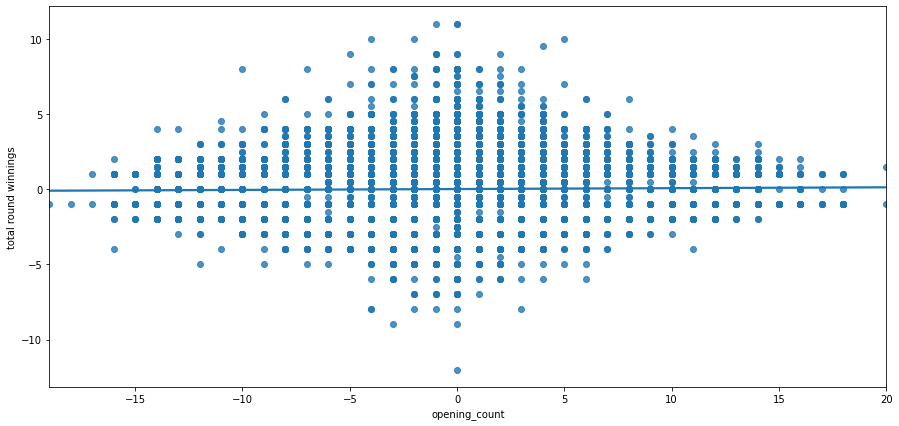

In [28]:
sns.regplot(x=df_basic['opening_count'], y=df_basic['total_round_winnings'])
plt.xlabel('opening_count')
plt.ylabel('total round winnings')
plt.show()

In [29]:
def count_winnings_test(df):
    df_basic = df[df['strategy']=='basic']
    oc = np.array(df_basic['opening_count'])
    trw = np.array(df_basic['total_round_winnings'])
    true_coef = np.corrcoef(oc,trw)[0][1]
    
    permuted_coefs = []
    np.random.seed(9)
    for i in range(2000):
        trw_perm = np.random.permutation(trw)
        perm_coef = np.corrcoef(oc,trw_perm)[0][1]
        permuted_coefs.append(perm_coef)


    permuted_coefs = np.array(permuted_coefs)
    
    conf_int95 = np.percentile(permuted_coefs, [2.5,97.5])
    
    conf_int99 = np.percentile(permuted_coefs, [0.5,99.5])
    
    p_value = np.sum(permuted_coefs >= true_coef)/2000
    
    print('True correlation coefficient: ', true_coef)
    print('95% confidence interval: ', conf_int95)
    print('99% confidence interval: ', conf_int99)
    print('p-value: ', p_value)
    
    sns.regplot(x=df_basic['opening_count'], y=df_basic['total_round_winnings'])
    plt.xlabel('opening_count')
    plt.ylabel('total round winnings')
    plt.show()

True correlation coefficient:  0.011926960133880846
95% confidence interval:  [-0.00184684  0.00198571]
99% confidence interval:  [-0.00260893  0.00258524]
p-value:  0.0


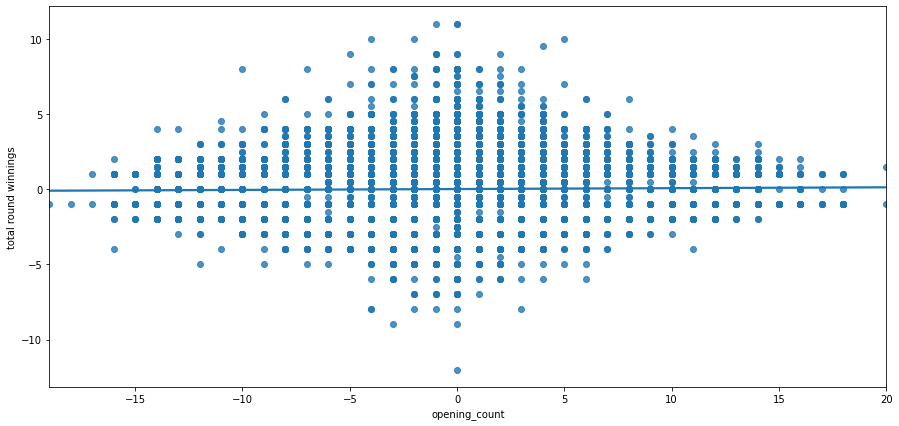

In [30]:
count_winnings_test(df)

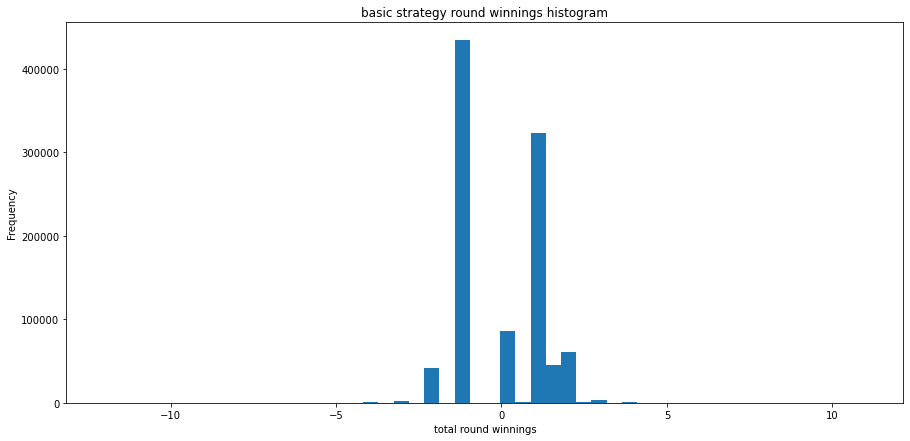

In [31]:
plt.hist(df_basic['total_round_winnings'], bins=50)
plt.title('basic strategy round winnings histogram')
plt.xlabel('total round winnings')
plt.ylabel('Frequency')
plt.show()

In [32]:
df_basic.describe()

,decks,pen,opening_count,cards_left,spots,total_round_winnings,accumulated_winnings
count,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000.000000
mean,6.0,1.5,-0.043995,190.676268,1.0,0.004443,2331.347320
std,0.0,0.0,2.408798,68.521215,0.0,1.169036,1497.339038
min,6.0,1.5,-19.000000,58.000000,1.0,-12.000000,-56.000000
25%,6.0,1.5,-1.000000,131.000000,1.0,-1.000000,801.500000
50%,6.0,1.5,0.000000,191.000000,1.0,0.000000,2559.500000
75%,6.0,1.5,1.000000,250.000000,1.0,1.000000,3757.000000
max,6.0,1.5,20.000000,308.000000,1.0,11.000000,4619.000000


## Hypothesis test for relation between change in count and total round winnings

In [33]:
# first create the column for change in counts: count_delta

df_basic['count_delta'] = np.append(np.diff(df_basic['opening_count']),[0])
df_basic.head()

<ipython-input-33-e7ee91d53d5d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basic['count_delta'] = np.append(np.diff(df_basic['opening_count']),[0])


,decks,pen,Blackjack_pays,Dealer_seventeen,strategy,spread,opening_count,cards_left,spots,bets,double_down,player_hands,dealer_hand,player_results,dealer_result,insurance,player_winnings_by_hand,total_round_winnings,accumulated_winnings,count_delta
0,6,1.5,"[3, 2]",H17,basic,NaN,0,307,1,[1],[False],"[[8, 5, 10]]","[10, 10]",[['bust']],['stand'],False,[-1.0],-1.0,-1.0,0
1,6,1.5,"[3, 2]",H17,basic,NaN,0,299,1,[1],[False],"[[10, 6]]","[4, 5, 3, 'A', 3, 5]",[['stand']],['stand'],False,[-1.0],-1.0,-2.0,0
2,6,1.5,"[3, 2]",H17,basic,NaN,0,294,1,[1],[False],"[[9, 4, 6]]","[10, 10]",[['stand']],['stand'],False,[-1.0],-1.0,-3.0,0
3,6,1.5,"[3, 2]",H17,basic,NaN,0,288,1,[1],[False],"[[10, 10]]","[2, 5, 6, 7]",[['stand']],['stand'],False,[0.0],0.0,-3.0,0
4,6,1.5,"[3, 2]",H17,basic,NaN,0,283,1,[1],[False],"[[8, 10]]","['A', 'A', 9]",[['stand']],['stand'],False,[-1.0],-1.0,-4.0,0


In [38]:
# obtain correlation coefficient between count delta and total round winnings

cd = df_basic['count_delta'][:-1]
trw_delta = df_basic['total_round_winnings'][:-1]
delta_coef = np.corrcoef(cd,trw_delta)[0][1]
print(delta_coef)

-0.051397106538121025


The change in count and total round winnings are negatively correlated.  This makes sense because the count and total round winnings are positively related, and a high count corresponds to more 10s and aces in the deck, and that is beneficial for the player.  10s and aces are only benefecial to the player if they actually show up.  So the winnings are higher when the a 10 or aces is dealt to a player/dealer, and that corresponds to the count decreasing.

In [39]:
# permute total round winnings 2000 times
# null hypothesis: no relationship between count delta and winnings

permuted_delta_coefs = []
np.random.seed(6)
for i in range(2000):
    trw_delta_perm = np.random.permutation(trw_delta)
    perm_delta_coef = np.corrcoef(cd,trw_delta_perm)[0][1]
    permuted_delta_coefs.append(perm_delta_coef)

    
permuted_delta_coefs = np.array(permuted_delta_coefs)



In [40]:
print(np.percentile(permuted_delta_coefs, [2.5,97.5]))

[-0.00196929  0.00197863]


The correlation coefficient for count delta is well outside of the 95% confidence interval under the permutation test.

In [41]:
print(np.percentile(permuted_delta_coefs, [0.5,99.5]))

[-0.00255131  0.00267737]


Also outside the 99% interval.

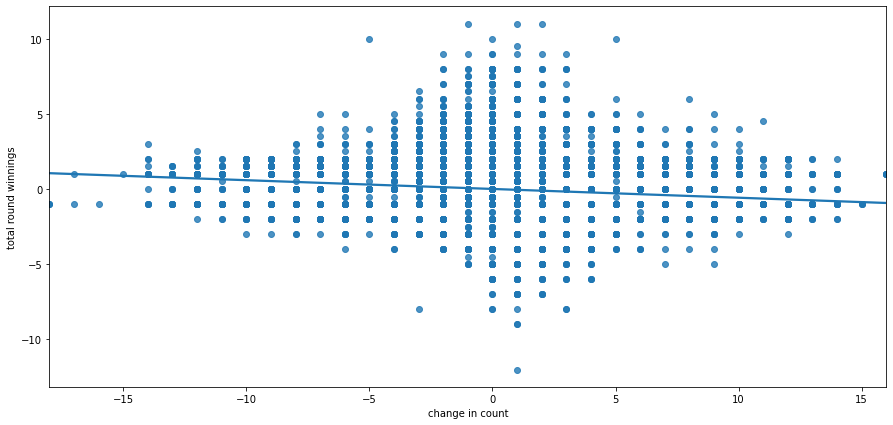

In [42]:
sns.regplot(x=df_basic['count_delta'], y=df_basic['total_round_winnings'])
plt.xlabel('change in count')
plt.ylabel('total round winnings')
plt.show()

In [43]:
def count_delta_winnings_test(df):
    df_basic = df[df['strategy'] == 'basic']
    df_basic['count_delta'] = np.append(np.diff(df_basic['opening_count']),[0])
    df_basic['cards_delta'] = np.append(np.diff(df_basic['cards_left']), [0])
    df_neg = df_basic[df_basic['cards_delta']<=0]
    
    cd = df_neg['count_delta'][:-1]
    trw_delta = df_neg['total_round_winnings'][:-1]
    delta_coef = np.corrcoef(cd,trw_delta)[0][1]
    
    permuted_delta_coefs = []
    np.random.seed(6)
    for i in range(2000):
        trw_delta_perm = np.random.permutation(trw_delta)
        perm_delta_coef = np.corrcoef(cd,trw_delta_perm)[0][1]
        permuted_delta_coefs.append(perm_delta_coef)


    permuted_delta_coefs = np.array(permuted_delta_coefs)
    
    conf_int95 = np.percentile(permuted_delta_coefs, [2.5,97.5])
    
    conf_int99 = np.percentile(permuted_delta_coefs, [0.5,99.5])
    
    p_value = np.sum(permuted_delta_coefs <= delta_coef)/2000
    
    print('True correlation coefficient: ', delta_coef)
    print('95% confidence interval: ', conf_int95)
    print('99% confidence interval: ', conf_int99)
    print('p-value: ', p_value)
    
    sns.regplot(x=df_neg['count_delta'], y=df_neg['total_round_winnings'])
    plt.xlabel('change in count')
    plt.ylabel('total round winnings')
    plt.show()
    

In [ ]:
new = pd.read_csv('1000000_samples/dataframes/0__2_decks_pen_0.5_BJpays_[3, 2]_dealerplays_S17_1000000_samples.csv')

In [ ]:
count_winnings_test(new)

In [ ]:
count_delta_winnings_test(new)

In [ ]:
new[new['strategy']=='counter'].head(35)

In [ ]:
new.loc[3999999,'accumulated_winnings']

In [ ]:
_ = losses(new[new['strategy']=='counter'])

In [ ]:
passport_path = '/Volumes/My Passport/Blackjack/BlackjackEngine/1000000_samples/dataframes'

In [ ]:
new_2 = pd.read_csv('/Volumes/My Passport/Blackjack/BlackjackEngine/1000000_samples/dataframes/38__6_decks_pen_1.5_BJpays_[3, 2]_dealerplays_H17_1000000_samples.csv')

In [ ]:
new_2.tail(30)

In [ ]:
count_winnings_test(new_2)

## Time series analysis

Autoregression

In [ ]:
mod = ARMA(df_counter['total_round_winnings'], order=(2,0))
res = mod.fit()
res.summary()

In [ ]:
plot_pacf(df_counter['total_round_winnings'], lags = 500, alpha = 0.05)

# Regression

Train a model to predict expected value, min losses given a certain game and bet spread.

## Expected Value Regression

In [44]:
passport_path = '/Volumes/My Passport/Blackjack/BlackjackEngine/1000000_samples/dataframes'

decks = [2,4,6]
pens = [0.5, 1, 1.5, 2]
seventeens = ['S17','H17']
BJpayouts = [[3,2],[6,5]]

product = []
j = 0
for deck in decks:
    for pen in pens:
        for seventeen in seventeens:
            for BJpays in BJpayouts:
                if pen == deck:
                    continue
                else:
                    product.append((passport_path,j,deck,pen,BJpays,seventeen))
                    j += 1

paths = ['%s/%s__%s_decks_pen_%s_BJpays_%s_dealerplays_%s_1000000_samples.csv'%p for p in product]

In [45]:
%%capture

start = time.time()

deck_list =[]
pen_list = []
BJpays_list = []
seventeen_list = []
spread_list = []
EV_list = []
min_losses_list = []

for path, p in zip(paths, product):
    deck_list.append(p[2])
    pen_list.append(p[3])
    BJpays_list.append(p[4])
    seventeen_list.append(p[5])
    
    
    df = pd.read_csv(path)
    spread_list.append(df.loc[0,'spread'])
    
    df_counter = df[df['strategy']=='counter']
    
    
    EV_list.append(np.mean(df_counter['total_round_winnings']))
    min_losses_list.append(np.percentile(losses(df_counter),[0,5])[1])
    
dic = {'deck':deck_list, 'pen':pen_list, 'BJpays':BJpays_list,\
       'seventeen':seventeen_list, 'spread':spread_list, 'expected_value':EV_list,\
      'min_losses_fifth':min_losses_list}
    
s = pd.DataFrame(dic)
    
end = time.time()

In [46]:
print('time elapsed: ', end-start)

s

time elapsed:  2300.550358057022


,deck,pen,BJpays,seventeen,spread,expected_value,min_losses_fifth
0,2,0.5,"[3, 2]",S17,NaN,0.271570,-614.025
1,2,0.5,"[6, 5]",S17,NaN,0.139171,-1198.400
2,2,0.5,"[3, 2]",H17,NaN,0.267670,-657.500
3,2,0.5,"[6, 5]",H17,NaN,0.135186,-1214.410
4,2,1.0,"[3, 2]",S17,NaN,0.141199,-629.525
5,2,1.0,"[6, 5]",S17,NaN,0.053905,-1398.600
6,2,1.0,"[3, 2]",H17,NaN,0.128424,-755.000
7,2,1.0,"[6, 5]",H17,NaN,0.041259,-2133.210
8,2,1.5,"[3, 2]",S17,NaN,0.052647,-462.500
9,2,1.5,"[6, 5]",S17,NaN,0.013049,-969.000


In [47]:
a = {-1:[1, 1], 0:[1, 1], 1:[1, 2], 2:[4, 2], 3:[6, 2], 4:[8, 2], 5:[10, 2], 6:[12, 2]}

for tc in list(a.keys()):
    s['%s_count_bet'%(tc)] = a[tc][0]
    s['%s_count_spot'%(tc)] = a[tc][1]

s['BJpays'] = s['BJpays'].apply(str)
s = pd.get_dummies(s)

s.drop('BJpays_[6, 5]',axis=1,inplace=True)
s.drop('seventeen_S17',axis=1,inplace=True)

cols = ['expected_value', 'min_losses_fifth', 'deck', 'pen', 'BJpays_[3, 2]',
       'seventeen_H17', '-1_count_bet',
       '-1_count_spot', '0_count_bet', '0_count_spot', '1_count_bet',
       '1_count_spot', '2_count_bet', '2_count_spot', '3_count_bet',
       '3_count_spot', '4_count_bet', '4_count_spot', '5_count_bet',
       '5_count_spot', '6_count_bet', '6_count_spot']
s = s[cols]
s

,expected_value,min_losses_fifth,deck,pen,"BJpays_[3, 2]",seventeen_H17,-1_count_bet,-1_count_spot,0_count_bet,0_count_spot,...,2_count_bet,2_count_spot,3_count_bet,3_count_spot,4_count_bet,4_count_spot,5_count_bet,5_count_spot,6_count_bet,6_count_spot
0,0.271570,-614.025,2,0.5,1,0,1,1,1,1,...,4,2,6,2,8,2,10,2,12,2
1,0.139171,-1198.400,2,0.5,0,0,1,1,1,1,...,4,2,6,2,8,2,10,2,12,2
2,0.267670,-657.500,2,0.5,1,1,1,1,1,1,...,4,2,6,2,8,2,10,2,12,2
3,0.135186,-1214.410,2,0.5,0,1,1,1,1,1,...,4,2,6,2,8,2,10,2,12,2
4,0.141199,-629.525,2,1.0,1,0,1,1,1,1,...,4,2,6,2,8,2,10,2,12,2
5,0.053905,-1398.600,2,1.0,0,0,1,1,1,1,...,4,2,6,2,8,2,10,2,12,2
6,0.128424,-755.000,2,1.0,1,1,1,1,1,1,...,4,2,6,2,8,2,10,2,12,2
7,0.041259,-2133.210,2,1.0,0,1,1,1,1,1,...,4,2,6,2,8,2,10,2,12,2
8,0.052647,-462.500,2,1.5,1,0,1,1,1,1,...,4,2,6,2,8,2,10,2,12,2
9,0.013049,-969.000,2,1.5,0,0,1,1,1,1,...,4,2,6,2,8,2,10,2,12,2


In [48]:
s.to_csv('BJ_regression/summary_EV_min.csv')

In [ ]:
s = pd.read_csv('BJ_regression/summary_EV_min.csv')

0.9939872318734568


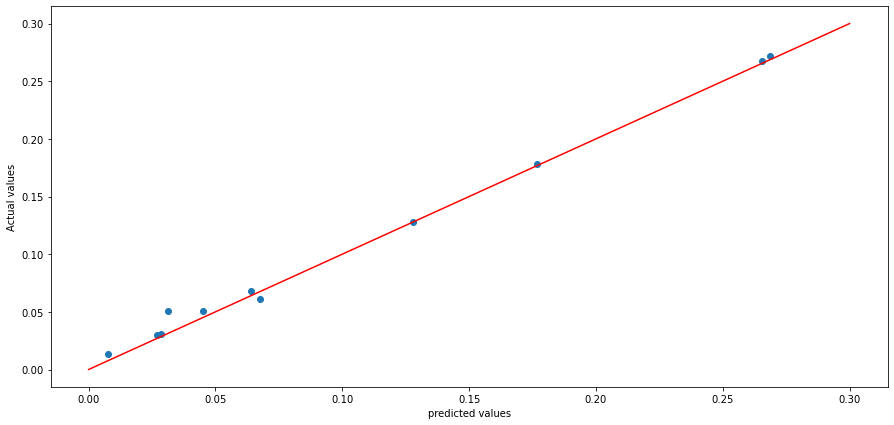

In [116]:
y = s['expected_value']
X = s.drop(['expected_value','min_losses_fifth'], axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=2, train_size=0.75)

poly = PolynomialFeatures(4)
X_train_poly = poly.fit_transform(X_train)
lm = LinearRegression()
lm.fit(X_train_poly,y_train)
X_test_poly = poly.fit_transform(X_test)
y_pred = lm.predict(X_test_poly)
print(r2_score(y_test,y_pred))

plt.scatter(y_pred, y_test)
plt.plot([0,.3],[0,.3],c='r')
plt.xlabel('predicted values')
plt.ylabel('Actual values')
plt.show()

Time elapsed:  10.701140880584717
0.7556052997522772
0.8671477109216252


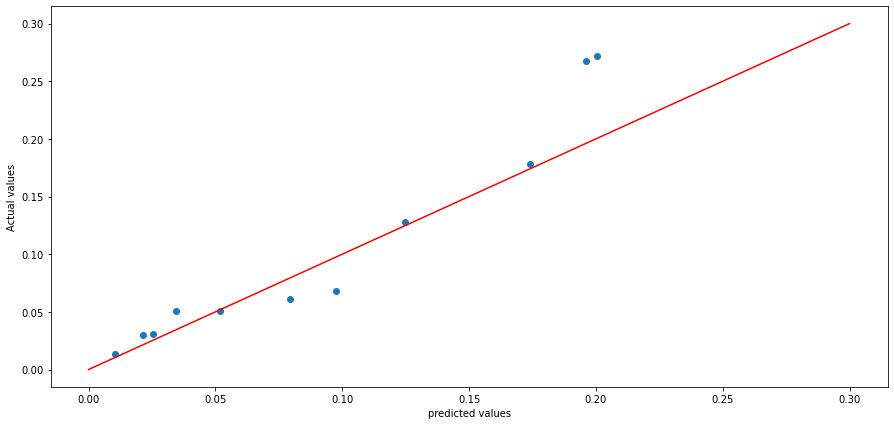

In [127]:
# GridSearchCV on polynomial regression:

y = s['expected_value']
X = s.drop(['expected_value','min_losses_fifth'], axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=2, train_size=0.75)

start = time.time()

steps = [('poly',PolynomialFeatures()), ('mlp', LinearRegression())]

degrees = [1,2,3,4,5,6,7]

polyreg_params = {'poly__degree':degrees}

polyreg_pipe = Pipeline(steps)

polyreg_EV_cv = GridSearchCV(polyreg_pipe, param_grid=polyreg_params, cv=3)

polyreg_EV_cv.fit(X_train,y_train)


end = time.time()

print('Time elapsed: ', end-start)


polyreg_df = pd.DataFrame(polyreg_cv.cv_results_)
polyreg_df.to_csv('BJ_regression/polyreg_cv_results.csv')
print(polyreg_cv.best_score_)

polyreg_EV = polyreg_EV_cv.best_estimator_
polyreg_EV.fit(X_train,y_train)
y_pred = polyreg_EV.predict(X_test)
print(r2_score(y_test,y_pred))

plt.scatter(y_pred, y_test)
plt.plot([0,0.3],[0,0.3],c='r')
plt.xlabel('predicted values')
plt.ylabel('Actual values')
plt.show()

Time elapsed:  1228.6518528461456
0.7875222642699473
0.5316753812028681


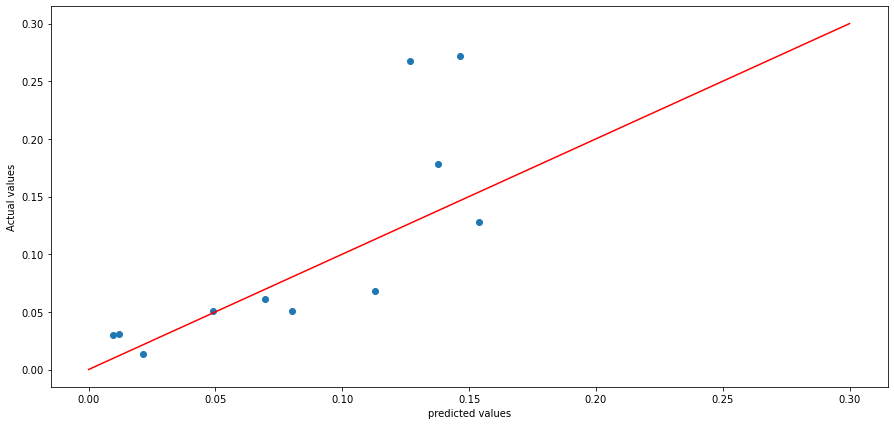

In [125]:
# GridSearchCV on random forest:

y = s['expected_value']
X = s.drop(['expected_value','min_losses_fifth'], axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=2, train_size=0.75)

start = time.time()

steps = [('RF', RandomForestRegressor(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=10)]

criteria = ['mse','mae']

depths = [int(n) for n in np.logspace(start=1, stop=2, num = 10)]

num_features = ['auto','sqrt','log2']

RF_params = {'RF__n_estimators': n_est,\
             'RF__criterion':criteria, 'RF__max_depth':depths, 'RF__max_features':num_features}

RF_pipe = Pipeline(steps)

RF_EV_cv = GridSearchCV(RF_pipe, param_grid=RF_params, cv=5)

RF_EV_cv.fit(X_train,y_train)



end = time.time()

print('Time elapsed: ', end-start)
             

RF_EV_df = pd.DataFrame(RF_EV_cv.cv_results_)
RF_EV_df.to_csv('BJ_regression/RF_EV_cv_results.csv')
print(RF_EV_cv.best_score_)

rf_EV = RF_EV_cv.best_estimator_
rf_EV.fit(X_train,y_train)
y_pred = rf_EV.predict(X_test)
print(r2_score(y_test,y_pred))

plt.scatter(y_pred, y_test)
plt.plot([0,0.3],[0,0.3],c='r')
plt.xlabel('predicted values')
plt.ylabel('Actual values')
plt.show()

Time elapsed:  100.67417907714844
0.5923561863397548
0.5924632859356689


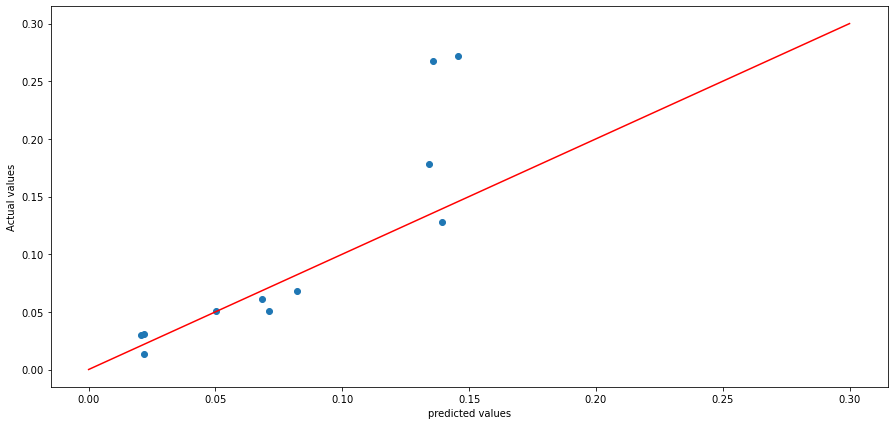

In [123]:
# GridSearchCV on AdaBoostClassifier:

y = s['expected_value']
X = s.drop(['expected_value','min_losses_fifth'], axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=2, train_size=0.75)

start = time.time()

steps = [('ada', AdaBoostRegressor(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=10)]

losses = ['linear','square','exponential']

lr = [0.01, 0.1, 1]

ada_params = {'ada__n_estimators': n_est, 'ada__learning_rate':lr, 'ada__loss':losses}

ada_pipe = Pipeline(steps)

ada_EV_cv = GridSearchCV(ada_pipe, param_grid=ada_params, cv=3)

ada_EV_cv.fit(X_train,y_train)



end = time.time()

print('Time elapsed: ', end-start)


ada_EV_df = pd.DataFrame(ada_EV_cv.cv_results_)
ada_EV_df.to_csv('BJ_regression/ada_EV_cv_results.csv')
print(ada_EV_cv.best_score_)

ada_EV = ada_EV_cv.best_estimator_
ada_EV.fit(X_train,y_train)
y_pred = ada_EV.predict(X_test)
print(r2_score(y_test,y_pred))

plt.scatter(y_pred, y_test)
plt.plot([0,0.3],[0,0.3],c='r')
plt.xlabel('predicted values')
plt.ylabel('Actual values')
plt.show()

Time elapsed:  14.336105108261108
0.6206860423388453
0.7528030497883392


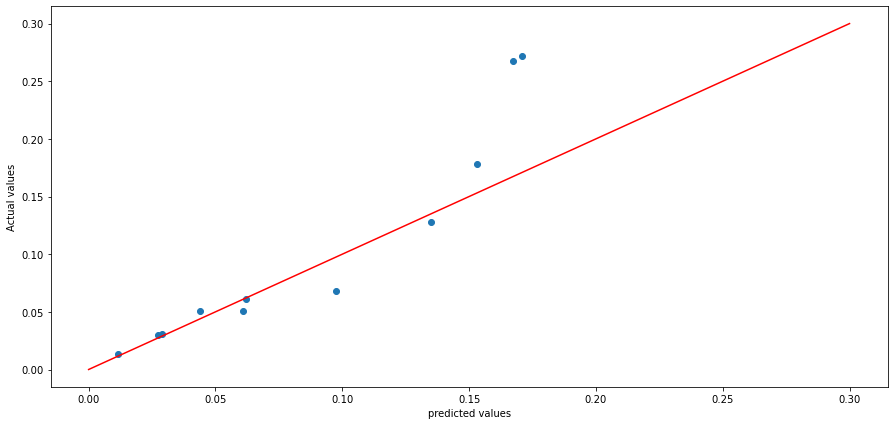

In [124]:
# GridSearchCV on GradientBoostingClassifier:
y = s['expected_value']
X = s.drop(['expected_value','min_losses_fifth'], axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=2, train_size=0.75)

start = time.time()

steps = [('gbc', GradientBoostingRegressor(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=5)]

depths = [3,7,15]

lr = [0.01, 0.1, 1]

gbc_params = {'gbc__n_estimators': n_est, 'gbc__learning_rate':lr, 'gbc__max_depth':depths}

gbc_pipe = Pipeline(steps)

gbc_EV_cv = GridSearchCV(gbc_pipe, param_grid=gbc_params, cv=3)

gbc_EV_cv.fit(X_train,y_train)



end = time.time()

print('Time elapsed: ', end-start)


gbc_EV_df = pd.DataFrame(gbc_EV_cv.cv_results_)
gbc_EV_df.to_csv('BJ_regression/gbc_EV_cv_results.csv')
print(gbc_EV_cv.best_score_)

gbc_EV = gbc_EV_cv.best_estimator_
gbc_EV.fit(X_train,y_train)
y_pred = gbc_EV.predict(X_test)
print(r2_score(y_test,y_pred))

plt.scatter(y_pred, y_test)
plt.plot([0,0.3],[0,0.3],c='r')
plt.xlabel('predicted values')
plt.ylabel('Actual values')
plt.show()

## Min Losses Regression

0.8509447504273364


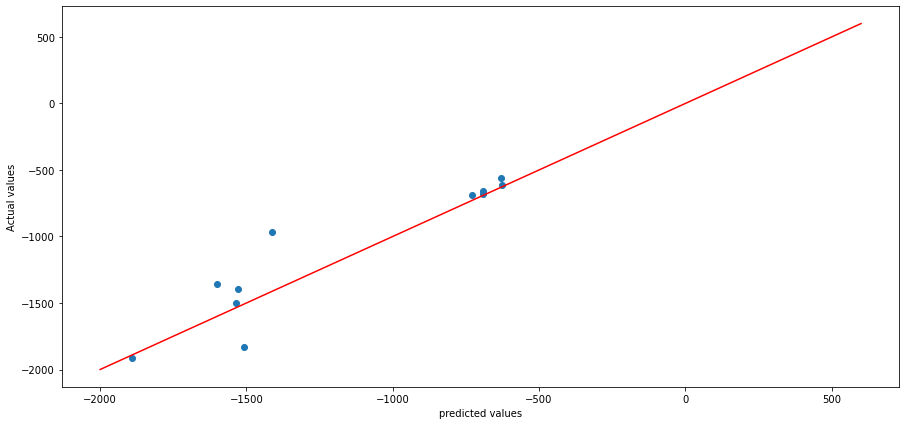

In [64]:
y = s['min_losses_fifth']
X = s.drop(['expected_value','min_losses_fifth'], axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=2, train_size=0.75)


rf = RandomForestRegressor(n_estimators=200,random_state=2)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(r2_score(y_test,y_pred))

plt.scatter(y_pred, y_test)
plt.plot([-2000,600],[-2000,600],c='r')
plt.xlabel('predicted values')
plt.ylabel('Actual values')
plt.show()

0.8684554562129039


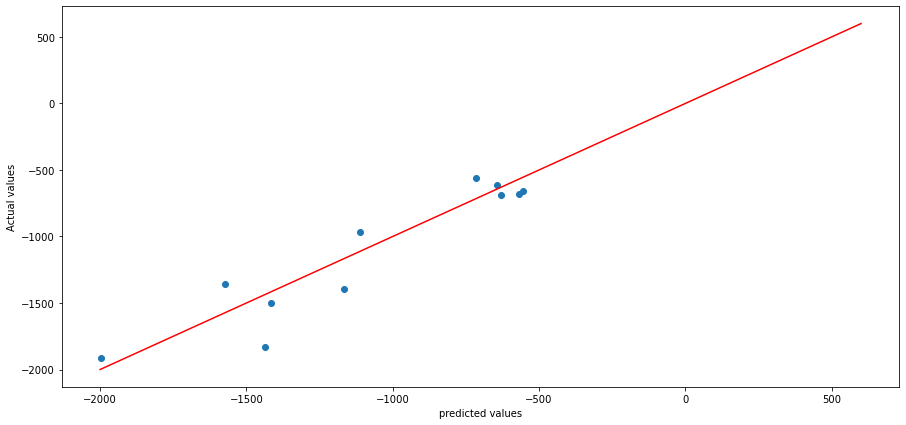

In [57]:
y = s['min_losses_fifth']
X = s.drop(['expected_value','min_losses_fifth'], axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=2, train_size=0.75)


rf = GradientBoostingRegressor(n_estimators=200,random_state=2)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(r2_score(y_test,y_pred))

plt.scatter(y_pred, y_test)
plt.plot([-2000,600],[-2000,600],c='r')
plt.xlabel('predicted values')
plt.ylabel('Actual values')
plt.show()

0.8679565911202938


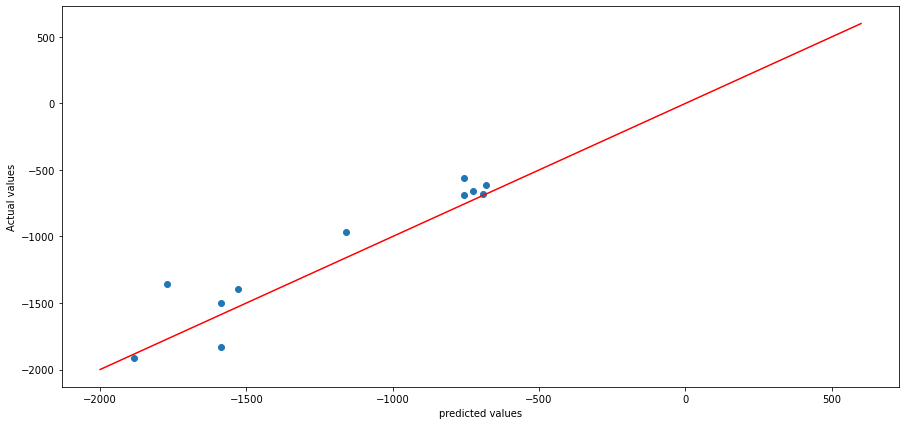

In [66]:
y = s['min_losses_fifth']
X = s.drop(['expected_value','min_losses_fifth'], axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=2, train_size=0.75)


rf = AdaBoostRegressor(n_estimators=200,random_state=2)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(r2_score(y_test,y_pred))

plt.scatter(y_pred, y_test)
plt.plot([-2000,600],[-2000,600],c='r')
plt.xlabel('predicted values')
plt.ylabel('Actual values')
plt.show()

Time elapsed:  1198.4271972179413
0.7128619088144397
0.8876274589783482


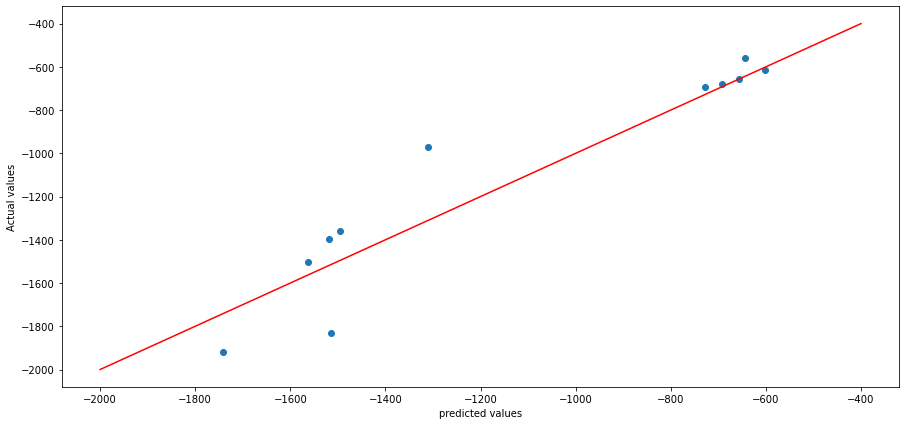

In [128]:
# GridSearchCV on random forest:

y = s['min_losses_fifth']
X = s.drop(['expected_value','min_losses_fifth'], axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=2, train_size=0.75)

start = time.time()

steps = [('RF', RandomForestRegressor(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=10)]

criteria = ['mse','mae']

depths = [int(n) for n in np.logspace(start=1, stop=2, num = 10)]

num_features = ['auto','sqrt','log2']

RF_params = {'RF__n_estimators': n_est,\
             'RF__criterion':criteria, 'RF__max_depth':depths, 'RF__max_features':num_features}

RF_pipe = Pipeline(steps)

RF_cv = GridSearchCV(RF_pipe, param_grid=RF_params, cv=5)

RF_cv.fit(X_train,y_train)



end = time.time()

print('Time elapsed: ', end-start)
             

RF_df = pd.DataFrame(RF_cv.cv_results_)
RF_df.to_csv('BJ_regression/RF_cv_results.csv')
print(RF_cv.best_score_)

rf = RF_cv.best_estimator_
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(r2_score(y_test,y_pred))

plt.scatter(y_pred, y_test)
plt.plot([-2000,-400],[-2000,-400],c='r')
plt.xlabel('predicted values')
plt.ylabel('Actual values')
plt.show()

Time elapsed:  77.06603288650513
0.7979382179640581
0.8221720590831005


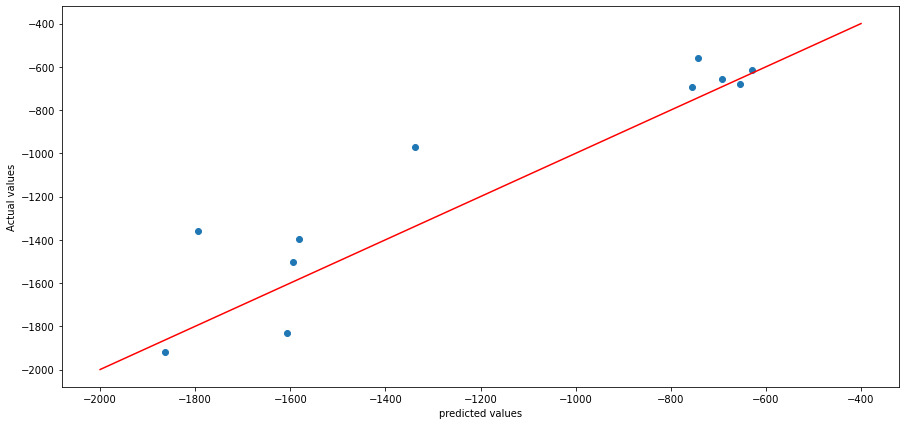

In [129]:
# GridSearchCV on AdaBoostClassifier:

y = s['min_losses_fifth']
X = s.drop(['expected_value','min_losses_fifth'], axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=2, train_size=0.75)

start = time.time()

steps = [('ada', AdaBoostRegressor(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=10)]

losses = ['linear','square','exponential']

lr = [0.01, 0.1, 1]

ada_params = {'ada__n_estimators': n_est, 'ada__learning_rate':lr, 'ada__loss':losses}

ada_pipe = Pipeline(steps)

ada_cv = GridSearchCV(ada_pipe, param_grid=ada_params, cv=3)

ada_cv.fit(X_train,y_train)



end = time.time()

print('Time elapsed: ', end-start)


ada_df = pd.DataFrame(ada_cv.cv_results_)
ada_df.to_csv('BJ_regression/ada_cv_results.csv')
print(ada_cv.best_score_)

ada = ada_cv.best_estimator_
ada.fit(X_train,y_train)
y_pred = ada.predict(X_test)
print(r2_score(y_test,y_pred))

plt.scatter(y_pred, y_test)
plt.plot([-2000,-400],[-2000,-400],c='r')
plt.xlabel('predicted values')
plt.ylabel('Actual values')
plt.show()

Time elapsed:  12.621154069900513
0.7996021851110413
0.8807213254434503


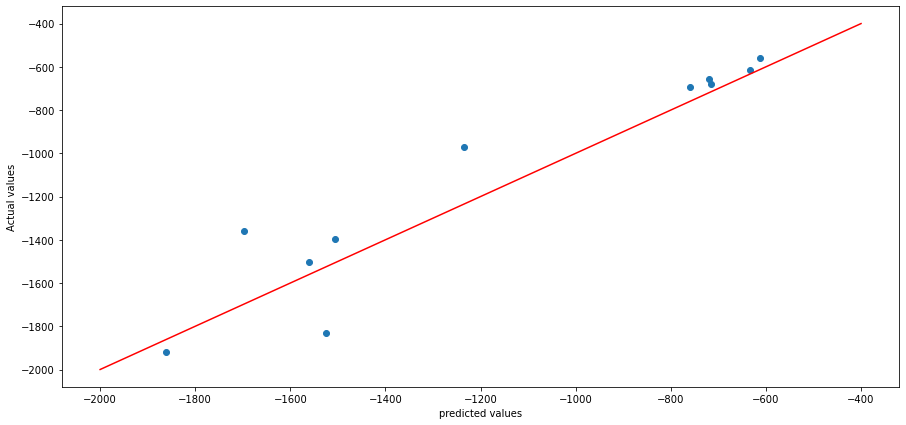

In [130]:
# GridSearchCV on GradientBoostingClassifier:
y = s['min_losses_fifth']
X = s.drop(['expected_value','min_losses_fifth'], axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=2, train_size=0.75)

start = time.time()

steps = [('gbc', GradientBoostingRegressor(random_state=2))]

n_est = [int(n) for n in np.logspace(start=1, stop=3, num=5)]

depths = [3,7,15]

lr = [0.01, 0.1, 1]

gbc_params = {'gbc__n_estimators': n_est, 'gbc__learning_rate':lr, 'gbc__max_depth':depths}

gbc_pipe = Pipeline(steps)

gbc_cv = GridSearchCV(gbc_pipe, param_grid=gbc_params, cv=3)

gbc_cv.fit(X_train,y_train)



end = time.time()

print('Time elapsed: ', end-start)


gbc_df = pd.DataFrame(gbc_cv.cv_results_)
gbc_df.to_csv('BJ_regression/gbc_cv_results.csv')
print(gbc_cv.best_score_)

gbc = gbc_cv.best_estimator_
gbc.fit(X_train,y_train)
y_pred = gbc.predict(X_test)
print(r2_score(y_test,y_pred))

plt.scatter(y_pred, y_test)
plt.plot([-2000,-400],[-2000,-400],c='r')
plt.xlabel('predicted values')
plt.ylabel('Actual values')
plt.show()